# Finalized classifier v2.0

Now all that's left to be done is wire up some routing logic between the models so we can easily do inference on incoming text. Workflow will looks something like this:

1. **Stage I features**: calculate perplexity ratio and TF-IDF based features for input text.
2. **Stage I classifier**: send feature vector to correct stage I classifiers based on text length.
3. **Stage II features**: create new feature vector for with stage I class probabilities, perplexity ration and TF-IDF features.
4. **Stage II classifier**: send new feature vector to correct stage II classifier for final prediction.

Each step requires assets from the feature engineering and classifier training phases. Let's make a checklist to help make sure we have everything in place.

1. **Stage I features**:
    - Perplexity ratio: tokenizer + reader and writer models.
    - Perplexity ratio Kullback-Leibler score: perplexity ratio Kullback-Leibler divergence kernel density estimate for each bin.
    - TF-IDF score: human and synthetic TF-IDF look-up tables for each bin.
    - TF-IDF Kullback-Leibler score: TF-IDF Kullback-Leibler divergence kernel density estimate for each bin.

2. **Stage I classifier**:
    - Trained XGBoost classifier model for each bin.

3. **Stage II features**
    - Perplexity ratio Kullback-Leibler score: perplexity ratio Kullback-Leibler divergence kernel density estimate for each bin.
    - TF-IDF score: human and synthetic TF-IDF look-up tables for each bin.
    - TF-IDF Kullback-Leibler score: TF-IDF Kullback-Leibler divergence kernel density estimate for each bin.

4. **Stage II classifier**
    - Trained XGBoost classifier model for each bin.

## 1. Notebook set-up

The plan is to break the inference pipeline into steps and run a process or process pool for each, using queues to move text through the pipeline. The major goal of this notebook will be to tune the pipeline in terms of resource allocation for each step to maximize the overall inference rate.

### 1.1. Imports

In [1]:
# Change working directory to parent so we can import as we would from main.py
print(f'Working directory: ', end = '')
%cd ..

# Standard imports
import time
import random

# PyPI imports
# import h5py
# import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Manager, Process

# Internal imports
import configuration as config
import functions.notebook_helper as helper_funcs

Working directory: /mnt/arkk/llm_detector/classifier


## 1.2. Notebook parameters

In [2]:
# Which experiments to run
pipeline_sanity_check=True
empty_queue_latency=True
full_queue_latency=True
queue_depth_latency=True

### 1.2. Inference pipeline class

Let's start with a class for the inference pipeline - it will deal with setting up the queues and worker processes.

In [3]:
class InferencePipeline:
    '''Holds and manages processes and queues for inference pipeline.'''

    def __init__(self, gpus: list):

        self.gpus=gpus

        ##########################################################
        # Set-up queues to move text though through the pipeline #
        ##########################################################

        # Star the multiprocessing manager.
        self.manager=Manager()

        # Accepts input text and takes it to the LLM worker(s) for 
        # perplexity ratio calculation.
        self.input_queue=self.manager.Queue(maxsize=10)

        # Takes text from LLM workers to the first stage classifier.
        self.stage_one_classifier_queue=self.manager.Queue(maxsize=10)

        # Takes text from the first stage classifier to the 
        # second stage classifier.
        self.stage_two_classifier_queue=self.manager.Queue(maxsize=10)

        # Returns completed work from the second stage classifier.
        self.output_queue=self.manager.Queue(maxsize=10)

        ##########################################################
        # Set-up a process for each step in the pipeline #########
        ##########################################################

        # Set-up a perplexity ratio score worker for each gpu.
        self.perplexity_ratio_processes=[]
        for gpu in gpus:
            self.perplexity_ratio_processes.append(
                Process(
                    target=helper_funcs.get_perplexity_ratio,
                    args=(
                        self.input_queue,
                        self.stage_one_classifier_queue,
                        gpu
                    )
                )
            )

        # Does the feature engineering and classification for stage I.
        self.stage_one_classifier_process=Process(
            target=helper_funcs.stage_one_classifier,
            args=(
                self.stage_one_classifier_queue,
                self.stage_two_classifier_queue,
                len(gpus)
            )
        )

        # Does the feature engineering and classification for stage II.
        self.stage_two_classifier_process=Process(
            target=helper_funcs.stage_two_classifier,
            args=(
                self.stage_two_classifier_queue,
                self.output_queue
            )
        )


    def start(self):
        '''Starts the pipeline processes.'''

        # Start LLM worker processes for perplexity ratio scoring
        # and wait for 'ready' response before moving on.
        for gpu_worker in self.perplexity_ratio_processes:
            gpu_worker.start()
            _=self.stage_one_classifier_queue.get()

        # Start stage I classifier process
        # and wait for 'ready' response before moving on.
        self.stage_one_classifier_process.start()
        _=self.stage_two_classifier_queue.get()

        # Start stage II classifier process
        # and wait for 'ready' response before moving on.
        self.stage_two_classifier_process.start()
        _=self.output_queue.get()


    def stop(self):
        '''Stops pipeline processes and shuts down.'''

        # Send a done signal for each GPU worker
        for _ in range(len(self.gpus)):
            self.input_queue.put('done')

        # Join and then close each process
        for gpu_worker in self.perplexity_ratio_processes:
            gpu_worker.join()
            gpu_worker.close()

        self.stage_one_classifier_process.join()
        self.stage_one_classifier_process.close()

        self.stage_two_classifier_process.join()
        self.stage_two_classifier_process.close()

        # Close the queues and stop the manager
        self.manager.shutdown()

## 2. Inference pipeline sanity check

In [4]:
if pipeline_sanity_check == True:

    # Create a pipeline class instance and start the worker processes
    inference_pipeline=InferencePipeline(['cuda:1','cuda:2'])
    inference_pipeline.start()

    # Send some test text though and take a look at the results
    test_text='''Documentation says you can equip node pools with GPU(s). A node pool is a group of nodes that share the same configuration. A node is an individual machine that runs containerized applications. So right now, we are running 3 'containers' (the telegram bot, the classification API and redis) on one 'node' in a 'node pool' with one member: pyrite. The only thing I am having trouble wrapping my mind around is how this scales past one node. I.e., if we go from one node to two, we have two redis servers, two classification APIs and two bots. I don't think that's what we want , but I'm not sure. I can think of two possibilities, each of which imply further questions.'''

    # Start timer for total time
    start_time=time.time()

    # Do the inference
    inference_pipeline.input_queue.put(test_text)
    result=inference_pipeline.output_queue.get()

    # Stop the timer and get the total time-of-flight
    dT=time.time() - start_time

    print(f'Total time-of-flight: {dT:.2f} seconds.\n')

    print(f'Time-of-flight by task:')
    for task, dT in result['Time-of-flight'].items():
        print(f' {task}: {dT:.2f}')

    print(f'\nFeatures:')
    for key, value in result['Features'].items():
        if key == 'Text string':
            print(f' {key}: {value[:75]}...')

        else:
            print(f' {key}: {value}')

    # Stop the pipeline
    inference_pipeline.stop()

## 3. Inference pipeline latency benchmarking

Results look OK at first glance. Seems like the inference latency is around 10 seconds for a single text. Let's send a bunch of text fragments from the training data through and see if we can get a better estimate of how fast the pipeline actually is.

### 3.1. Data loading

Load the stage I training data, take just the text and labels. We will be treating each fragment as if it were submitted by a user, i.e. all we will have is the text string. We will use the labels later to check the model's performance.

In [5]:
# Load the stage I training data and take just the text and labels

# Stage I dataset
dataset_name='falcon-7b_scores_v2_10-300_words_stage_I'

# Input file path
input_file=f'{config.DATA_PATH}/{dataset_name}.h5'

# Open the new hdf5 file with pandas so we can work with dataframes
data_lake=pd.HDFStore(input_file)

# Get the features and extract just the text
training_df=data_lake['training/combined/features']
texts=training_df['String'].to_list()
print(f'Have {len(texts)} training text fragments')

# Get the corresponding labels
labels=data_lake['training/combined/labels'].to_list()
print(f'Have {len(labels)} training text fragment labels')

# Close the connection to the hdf5 file
data_lake.close()

training_df.head()

Have 39042 training text fragments
Have 39042 training text fragment labels


,Fragment length (words),Fragment length (tokens),Source,String,Perplexity,Cross-perplexity,Perplexity ratio score,Perplexity ratio score Kullback-Leibler divergence,Human TF-IDF,Synthetic TF-IDF,TF-IDF score,TF-IDF score Kullback-Leibler divergence
0,32,46,human,It’s a disease people just don’t know about. T...,3.127,2.832031,1.104138,0.473190,-3.385168,-3.422211,-0.252168,0.071449
1,27,45,human,Owens(c) vs Roman Reigns – WWE Universal Champ...,2.912,3.027344,0.961935,0.120746,-2.634773,-2.650256,-0.081826,0.067688
2,268,371,synthetic,chemical or pharmaceutical processes.\nhowever...,2.193,2.675781,0.819708,3.325138,-2.862300,-2.877875,-0.089403,0.067875
3,112,131,human,unstable area near the Iraq and Syria border. ...,2.730,2.695312,1.013043,0.203559,-3.475644,-3.331192,0.983256,0.037913
4,32,44,synthetic,"ins , is encoded by a gene family with at leas...",3.025,3.693359,0.819143,3.306112,-2.650665,-2.901612,-1.393327,0.069538


### 3.2. Empty queue inference latency

In [6]:
if empty_queue_latency == True:
    
    # Number of text samples to send
    batch_size=100

    # Holder for results
    inference_times={
        'Total': [],
        'Perplexity ratio calculation': [],
        'Stage I classification': [],
        'Stage II classification': []
    }

    # Create a pipeline class instance and start the worker processes
    inference_pipeline=InferencePipeline(['cuda:1','cuda:2'])
    inference_pipeline.start()

In [7]:
%%time

if empty_queue_latency == True:

    # Grab a random sample of texts for this batch
    batch=random.sample(texts, batch_size)

    # Counter for texts processed - in case we skip some due to 
    # errors in the pipeline
    text_count=0

    # Loop on the batch and run inference on each text
    for i, text in enumerate(batch):

        # Record total time-of-flight for this text
        start_time=time.time()

        # Do the inference
        inference_pipeline.input_queue.put(text)
        result=inference_pipeline.output_queue.get()

        # Stop the total time-of-flight timer
        dT=time.time() - start_time

        # Check to make sure we got a good result
        if result['Status'] == 'OK':

            # Collect the times
            inference_times['Total'].append(dT)
            inference_times['Perplexity ratio calculation'].append(result['Time-of-flight']['Perplexity ratio calculation (seconds)'])
            inference_times['Stage I classification'].append(result['Time-of-flight']['Stage I classifier (seconds)'])
            inference_times['Stage II classification'].append(result['Time-of-flight']['Stage II classifier (seconds)'])
    
    inference_pipeline.stop()

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs


#### 3.2.1. Results

In [8]:
if empty_queue_latency == True:

    # Create dataset-wide bins
    min_time=min(min(np.log(times)) for times in inference_times.values())
    max_time=max(max(np.log(times)) for times in inference_times.values())
    bins=np.linspace(min_time, max_time, num=50)

    plt.title('Inference pipeline time-of-flight')
    plt.xlabel('Elapsed time log10(seconds per text)')
    plt.ylabel('Count (texts)')

    for variable, times in inference_times.items():

        plt.hist(np.log(times), label=variable, bins=bins, alpha=0.5)

    plt.legend(loc='best')
    plt.show()

Not surprisingly, the perplexity ratio calculation accounts for almost all of the net inference time. This is going to be hard to get around, it's the step that uses two LLMs to score the text. We barely have enough local compute to run two GPU workers processes - each one needs ~ 12 GB GPU memory. Once on google cloud, we may be able to use multiple GPU workers per big GPU, but I have not seen speedups from multiple workers on the same GPU with Transformers and Torch, even if everything fits in memory. Maybe the only way to scale effectively is more GPU nodes? Or can I get multiple GPUs on the same node...

Let's at least try 1 vs 2 GPU workers locally. To see any difference, we need to submit the text a different way - rather than putting one text in the input queue and waiting for it to come out the other end - let's put a big batch in all at once and time how long it takes to recover all of them. Hypothesis here is that two GPU workers should cut the average time down, even though the time-of-flight for any one text will remain the same. This is a better representation of an end-user's experience anyway. Imagine you just submitted something but there are 10 people in the queue ahead of you - it will take 10 seconds for each fragment already in the queue and then 10 seconds for yours. But if there are more GPU workers ingesting and we cut the time per fragment down, you will feel a bigger effect than just the increased speed of scoring for your own fragment. Say we take the per fragment time from 10 seconds to 5, now it will be 55 seconds before you get an answer, rather than 110.

### 3.3. Full queue mean latency: 1 vs 2 GPU workers

In [9]:
if full_queue_latency == True:

    # GPUs to run jobs on
    gpu_worker_lists=[['cuda:1'],['cuda:1','cuda:2']]

    # Number of texts to score
    batch_size=100

    # Holder for results
    inference_times={}

In [10]:
%%time

if full_queue_latency == True:

    # Loop on the GPU worker lists
    for gpus in gpu_worker_lists:

        print(f'\nRunning batch with {len(gpus)} GPU workers')

        # Create a pipeline class instance and start the worker processes
        inference_pipeline=InferencePipeline(gpus)
        inference_pipeline.start()

        # Add a key and list to the results for this worker count to collect average rates
        inference_times[f'{len(gpus)} GPU workers']=[]

        # Grab a random sample of texts for this batch
        batch=random.sample(texts, batch_size)

        # Start the timer
        start_time=time.time()

        # Put all of the text in the queue
        print(f' Submitting {batch_size} texts to queue')
        for i, text in enumerate(batch):
            inference_pipeline.input_queue.put(text)

        # Send a done signal to each gpu
        for gpu in gpus:
            inference_pipeline.input_queue.put('done')

        print(' Waiting...')

        # Loop, collecting output arrival times until we get done 
        # from the output queue
        while True:
            result=inference_pipeline.output_queue.get()
            if result['Status'] == 'done':
                break
            elif result['Status'] == 'OK':
                dT=time.time() - start_time
                inference_times[f'{len(gpus)} GPU workers'].append(dT)
    
        # Cleanly finish shutting the pipeline down
        inference_pipeline.stop()

#### 3.3.1. Results

In [11]:
if full_queue_latency == True:

    plt.title('Mean full queue inference latency')
    plt.xlabel('Response time (seconds)')
    plt.ylabel('Count (texts)')

    # Create dataset-wide bins
    min_inference_time=min(min(inference_time) for inference_time in inference_times.values())
    max_inference_time=max(max(inference_time) for inference_time in inference_times.values())
    bins=np.linspace(min_inference_time, max_inference_time, num=50)

    for variable, times in inference_times.items():

        plt.hist(times, label=variable, bins=bins, alpha=0.5)

    plt.legend(loc='best')
    plt.show()

### 3.4. Latency as a function of queue depth

For bonus points, let's come up with a scaling law, i.e. what's the worst case scenario for latency as the queue gets longer and does adding an extra GPU worker help? (yes).

In [12]:
if queue_depth_latency == True:

    # GPUs to run jobs on
    gpu_worker_lists=[['cuda:1'],['cuda:1','cuda:2']]

    # Number of texts to add to the queue
    queue_depths=[1,2,4,8,16]

    # Number of replicates to run for each queue depth
    replicates=3

    # Holder for results
    inference_times={}

In [14]:
%%time

if queue_depth_latency == True:

    # Loop on the GPU worker lists
    for gpus in gpu_worker_lists:

        # Add a key to the results for this GPU count to hold
        # the queue depth and the time
        inference_times[f'{len(gpus)} GPU workers']={}

        # Loop on the queue depths
        for queue_depth in queue_depths:
            print(f'Running queue depth {queue_depth} with {len(gpus)} GPU workers')

            # Add a key to the results for this queue depth to hold the time
            inference_times[f'{len(gpus)} GPU workers'][f'Queue depth {queue_depth}']=[]

            # Finally, loop on the replicates of this queue depth
            for replicate in range(replicates):

                # Create a pipeline class instance and start the worker processes
                inference_pipeline=InferencePipeline(gpus)
                inference_pipeline.start()

                # Grab a random sample of texts of size queue_depth for this batch
                batch=random.sample(texts, queue_depth)

                # Start the timer
                start_time=time.time()
                
                # Put all of the text in the queue
                for i, text in enumerate(batch):
                    inference_pipeline.input_queue.put(text)

                # Send a done signal to each gpu
                for gpu in gpus:
                    inference_pipeline.input_queue.put('done')

                # Loop, collecting output arrival times until we get done 
                # from the output queue
                while True:
                    result=inference_pipeline.output_queue.get()
                    if result['Status'] == 'done':
                        break
                    elif result['Status'] == 'OK':
                        dT=time.time() - start_time

                # Collect the last dT for is replicate of this queue depth
                inference_times[f'{len(gpus)} GPU workers'][f'Queue depth {queue_depth}'].append(dT)
                
                # Cleanly finish shutting the pipeline down
                inference_pipeline.stop()

Running queue depth 1 with 1 GPU workers
Running queue depth 2 with 1 GPU workers
Running queue depth 4 with 1 GPU workers
Running queue depth 8 with 1 GPU workers
Running queue depth 1 with 2 GPU workers
Running queue depth 2 with 2 GPU workers
Running queue depth 4 with 2 GPU workers
Running queue depth 8 with 2 GPU workers


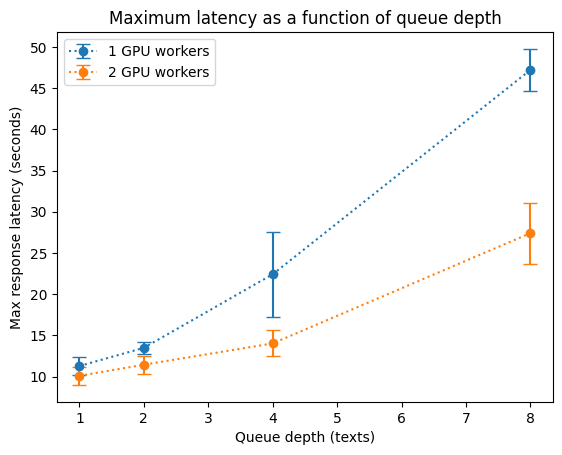

In [15]:
if queue_depth_latency is True:
    
    plt.title('Maximum latency as a function of queue depth')
    plt.xlabel('Queue depth (texts)')
    plt.ylabel('Max response latency (seconds)')

    for gpus in gpu_worker_lists:
        data=inference_times[f'{len(gpus)} GPU workers']
        standard_deviations=[]
        means=[]

        for queue_depth in queue_depths:
            times=data[f'Queue depth {queue_depth}']
            means.append(np.mean(times))
            standard_deviations.append(np.std(times))

        plt.errorbar(
            queue_depths, 
            means, 
            yerr=standard_deviations, 
            linestyle='dotted',
            marker='o', 
            capsize=5,
            label=f'{len(gpus)} GPU workers'
        )

    plt.legend(loc='best')
    plt.show()

Yep, so not surprisingly - adding a GPU worker cuts down the max latency at all queue depths. But even with two workers (using a full 24 GB of GPU memory) the latency gets pretty bad quickly as the queue grows.

Unfortunately, I don't think there is much we can do but throw more GPUs at it. Google Cloud credits for the win! We are going to have to build with this in mind though - we don't want to task a bunch of GPUs right out of the gate and burn all of our credits waiting for people to show up - but if they do, we want to be prepared to scale and keep the wait times under control.